# View the simulated spectrum of CTIO Data in January 2017
==================================================================================================

- author : Sylvie Dagoret-Campagne
- date   : January 19th 2017
- update : January 24th


This reads all the simulated fits spectra in order to build a single fits file of all simulated spectra.


In [28]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "theNotebook = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [29]:
print theNotebook

View_SimSpectrum_HD60753


In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits
import re
import os

In [31]:
import ccdproc
print 'ccdproc version',ccdproc.__version__

from astropy.modeling import models

ccdproc version 1.0.1


In [32]:
from scipy import stats  
from scipy import ndimage
from datetime import datetime, timedelta
from mpl_toolkits.mplot3d import Axes3D
import scipy.signal

In [33]:
import bottleneck as bn  # numpy's masked median is slow...really slow (in version 1.8.1 and lower)
print 'bottleneck version',bn.__version__

bottleneck version 1.0.0


In [34]:
import photutils
from astropy.stats import sigma_clipped_stats
from photutils import daofind
from photutils import CircularAperture
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
#from photutils.background import Background2D
from photutils import Background2D, SigmaClip, MedianBackground

In [35]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [36]:
from IPython.display import Image, display

In [37]:
import matplotlib
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

In [38]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (4, 4),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [39]:
############################################################################
def ensure_dir(f):
    d = os.path.dirname(f)
    if not os.path.exists(f):
        os.makedirs(f)
#########################################################################

In [40]:

object_name='HD60753'

### Output directory for images generated in the notebook view (not true fits images)

In [41]:
dir_top_images="images_notebooks/"+theNotebook ### Top directory to save images

In [42]:
ensure_dir(dir_top_images)

### Fits Output file
--------------------

- Gather the simulate spectra in a single fits file
- This is because one is limited in the number of fits file whcih can be open
- Used in a latter step.

In [43]:
outputfitsfile='AllSimSpectra_'+object_name+'.fits'

In [44]:
#ensure_dir(outputdir)

### Input fits file
-----------------
- Location of the simulated spectra for the dataset

In [45]:
#simspecdir='/Users/dagoret-campagnesylvie/MacOsX/LSST/MyWork/GitHub/CTIOAna2017/simu_spectra/fits/HD14943/2017_01'
simspecdir='/Users/dagoret-campagnesylvie/MacOsX/LSST/MyWork/GitHub/CTIOAna2017/simu_spectra/fits/HD60753/2017_01_18/R400_289_427'

In [46]:
!pwd

/Users/dagoret-campagnesylvie/MacOsX/LSST/MyWork/GitHub/CTIOAna2017/2017_01_18/R400_289_427


## Read the simulated spectra

In [47]:
inputsim_filelist=os.listdir(simspecdir) 

In [48]:
if '.DS_Store' in inputsim_filelist:
    inputsim_filelist.remove('.DS_Store')
inputsim_filelist=np.array(inputsim_filelist)

In [49]:
print inputsim_filelist[0:5]

['RT_CT_pp_us_sa_rt_HD60753_Nev289_y2016_m01_aver_spectra.fits'
 'RT_CT_pp_us_sa_rt_HD60753_Nev290_y2016_m01_aver_spectra.fits'
 'RT_CT_pp_us_sa_rt_HD60753_Nev291_y2016_m01_aver_spectra.fits'
 'RT_CT_pp_us_sa_rt_HD60753_Nev292_y2016_m01_aver_spectra.fits'
 'RT_CT_pp_us_sa_rt_HD60753_Nev293_y2016_m01_aver_spectra.fits']


In [50]:
print re.findall('^RT_CT_pp_us_sa_rt_HD14943_Nev(.*)_y2016_m01_aver_spectra.fits',inputsim_filelist[0])

[]


In [51]:
indexes_simfiles= [] # global list
filelist_simfitspec= []  # global list

In [52]:
#%%cython

import numpy as np
import re

def MakeSimFileList(inputdir,input_filelist):
    """
    MakeFileList : Make The List of files to open
    =============
    """
    
#    import numpy as np
#    import re
    indexes_files= [] # global list
    filelist_fitsimages= []  # global list
    index=0

    
    for file in input_filelist: # loop on directories, one per image       
            filename=inputdir+'/'+file
            if re.search('.*fits$',filename):  #example of filename filter
                index=index+1
                filelist_fitsimages.append(filename)
                str_num=re.findall('^RT_CT_pp_us_sa_rt_HD60753_Nev(.*)_y2016_m01_aver_spectra.fits',file)
                number=int(str_num[0])
                indexes_files.append(number)
    return indexes_files, filelist_fitsimages

In [53]:
indexes_simfiles, filelist_simfitspec=MakeSimFileList(simspecdir,inputsim_filelist)   # filter to take only fits file

In [54]:
# transform into numpy arrays
indexes_simfiles=np.array(indexes_simfiles)
filelist_simfitspec=np.array(filelist_simfitspec)

In [55]:
print indexes_simfiles

[289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306
 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323 324
 325 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340 341 342
 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360
 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375 376 377 378
 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393 394 395 396
 397 398 399 400 401 402 403 404 405 406 407 408 409 410 411 412 413 414
 415 416 417 418 419 420 421 422 423 424 425 426 427]


In [56]:
sorted_simindexes=np.argsort(indexes_simfiles) # sort the file indexes

In [57]:
sorted_simindexes

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138])

In [58]:
sorted_simnumbers=indexes_simfiles[sorted_simindexes] # check the ordering with argsort is correct

In [59]:
print sorted_simnumbers # check

[289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306
 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323 324
 325 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340 341 342
 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360
 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375 376 377 378
 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393 394 395 396
 397 398 399 400 401 402 403 404 405 406 407 408 409 410 411 412 413 414
 415 416 417 418 419 420 421 422 423 424 425 426 427]


In [60]:
sorted_simfiles=filelist_simfitspec[sorted_simindexes] # now sort the filenames

In [61]:
print sorted_simfiles[0:5] # check

[ '/Users/dagoret-campagnesylvie/MacOsX/LSST/MyWork/GitHub/CTIOAna2017/simu_spectra/fits/HD60753/2017_01_18/R400_289_427/RT_CT_pp_us_sa_rt_HD60753_Nev289_y2016_m01_aver_spectra.fits'
 '/Users/dagoret-campagnesylvie/MacOsX/LSST/MyWork/GitHub/CTIOAna2017/simu_spectra/fits/HD60753/2017_01_18/R400_289_427/RT_CT_pp_us_sa_rt_HD60753_Nev290_y2016_m01_aver_spectra.fits'
 '/Users/dagoret-campagnesylvie/MacOsX/LSST/MyWork/GitHub/CTIOAna2017/simu_spectra/fits/HD60753/2017_01_18/R400_289_427/RT_CT_pp_us_sa_rt_HD60753_Nev291_y2016_m01_aver_spectra.fits'
 '/Users/dagoret-campagnesylvie/MacOsX/LSST/MyWork/GitHub/CTIOAna2017/simu_spectra/fits/HD60753/2017_01_18/R400_289_427/RT_CT_pp_us_sa_rt_HD60753_Nev292_y2016_m01_aver_spectra.fits'
 '/Users/dagoret-campagnesylvie/MacOsX/LSST/MyWork/GitHub/CTIOAna2017/simu_spectra/fits/HD60753/2017_01_18/R400_289_427/RT_CT_pp_us_sa_rt_HD60753_Nev293_y2016_m01_aver_spectra.fits']


In [62]:
hdu_list=fits.open(sorted_simfiles[0])
header=hdu_list[0].header

In [63]:
print header

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                    8 / array data type                                NAXIS   =                    0 / number of array dimensions                     EXTEND  =                    T                                                  OBJ_NAME= 'HD60753 '                                                            AIRMASS =    1.083999991416931                                                  UNITS   = 'wavelength in nm'                                                    DATE    = '2017-01-19T05:14:07.108'                                             EXPOSURE=                 30.0                                                  FILENAME= 'trim_20170118_289.fits'                                              COMMENT Prediction of observable SPECTRA                                        END                                                                                                                     

In [64]:
 table_data=hdu_list[1].data

In [65]:
print table_data.columns

ColDefs(
    name = 'WAVELENGTH'; format = 'E'
    name = 'SEDcalspec'; format = 'E'
    name = 'Atmosphere'; format = 'E'
    name = 'QE'; format = 'E'
    name = 'SEDxQExATM'; format = 'E'
)


In [66]:
simwavelength = table_data.field('WAVELENGTH')
simsed        = table_data.field('SEDcalspec')
simatm        = table_data.field('Atmosphere')
simqe         = table_data.field('QE')
simspectra    = table_data.field('SEDxQExATM')

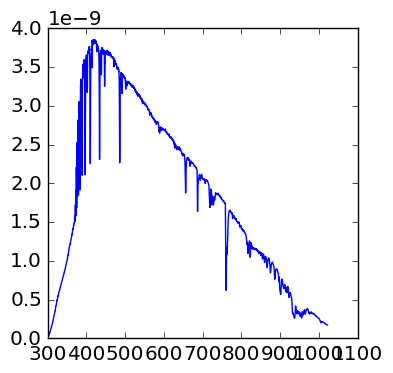

In [67]:
plt.plot(simwavelength,simspectra )

In [68]:
#%%cython

#import numpy as np
#from astropy.io import fits
def BuildSimSpec(sorted_filenames,sorted_numbers,object_name):
    """
    BuildSimSpec
    ===============
    """

    all_dates = []
    all_airmass = []
    
    all_simwavelength = []
    all_simspectra = []
    all_simatmosphere = []
    all_simqe = []
    all_simsed = []
    
    all_titles = []
    all_header = []
    all_expo = []
   
    NBFILES=sorted_filenames.shape[0]

    for idx in range(NBFILES):  
        

        file=sorted_filenames[idx]    
        
        hdu_list=fits.open(file)
        header=hdu_list[0].header
                
        #print header
        date_obs = header['DATE']
        airmass = header['AIRMASS']
        expo = header['EXPOSURE']
        num=sorted_numbers[idx]
        title=object_name+" z= {:3.2f} Nb={}".format(float(airmass),num)
        
        # now reads the spectra
        
        table_data=hdu_list[1].data
        
        simwavelength = table_data.field('WAVELENGTH')
        simsed        = table_data.field('SEDcalspec')
        simatm        = table_data.field('Atmosphere')
        simqe         = table_data.field('QE')
        simspectra    = table_data.field('SEDxQExATM')
        
        
        all_simwavelength.append(simwavelength)
        all_simspectra.append(simspectra)
        all_simatmosphere.append(simatm)
        all_simqe.append(simqe)
        all_simsed.append(simsed)
        
        all_dates.append(date_obs)
        all_airmass.append(float(airmass))
            
        all_titles.append(title)
        all_header.append(header)
        all_expo.append(expo)
        hdu_list.close()
        
    return all_dates,all_airmass,all_titles,all_header,all_expo,all_simwavelength,all_simspectra,all_simatmosphere,all_simqe,all_simsed

In [69]:
all_simdates,all_simairmass,all_simtitles,all_simheader,all_simexpo,all_simwavelength,all_simspectra,all_simatmosphere,all_simqe,all_simsed=BuildSimSpec(sorted_simfiles,sorted_simnumbers,object_name)

In [83]:
%%cython
import numpy as np
import matplotlib.pyplot as plt
import os

def ShowSpectra(all_wavelength,all_simspec,all_simtitles,object_name,dir_top_images):
    """
    ShowSpectra: Show the raw images without background subtraction
    ==============
    """
    NBIMAGES=len(all_simspec)
    MAXIMGROW=int(NBIMAGES/4)+1
    thex0 = []
    f, axarr = plt.subplots(MAXIMGROW,4,figsize=(25,100))
    f.tight_layout()
    #plt.subplot_tool() 
    for index in np.arange(0,NBIMAGES):
        ix=index%4
        iy=index/4
        wavelength=all_wavelength[index]
        spectrum=all_simspec[index]
        axarr[iy,ix].plot(wavelength,spectrum,'r-',lw=2)
        axarr[iy,ix].set_title(all_simtitles[index])
        #axarr[iy,ix].set_ylim(0.,200.)
        axarr[iy,ix].grid(True)
      
    title='simulated spectra spectra'
    plt.suptitle(title,size=16)
    figfilename=os.path.join(dir_top_images,'simulatedspectra.pdf')
    plt.savefig(figfilename)         

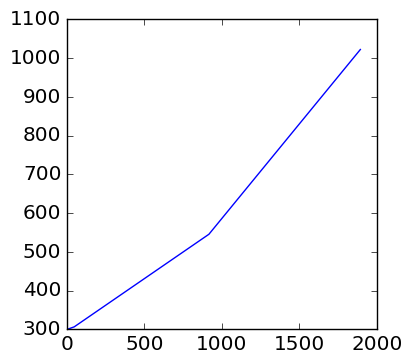

In [71]:
plt.plot(all_simwavelength[1])

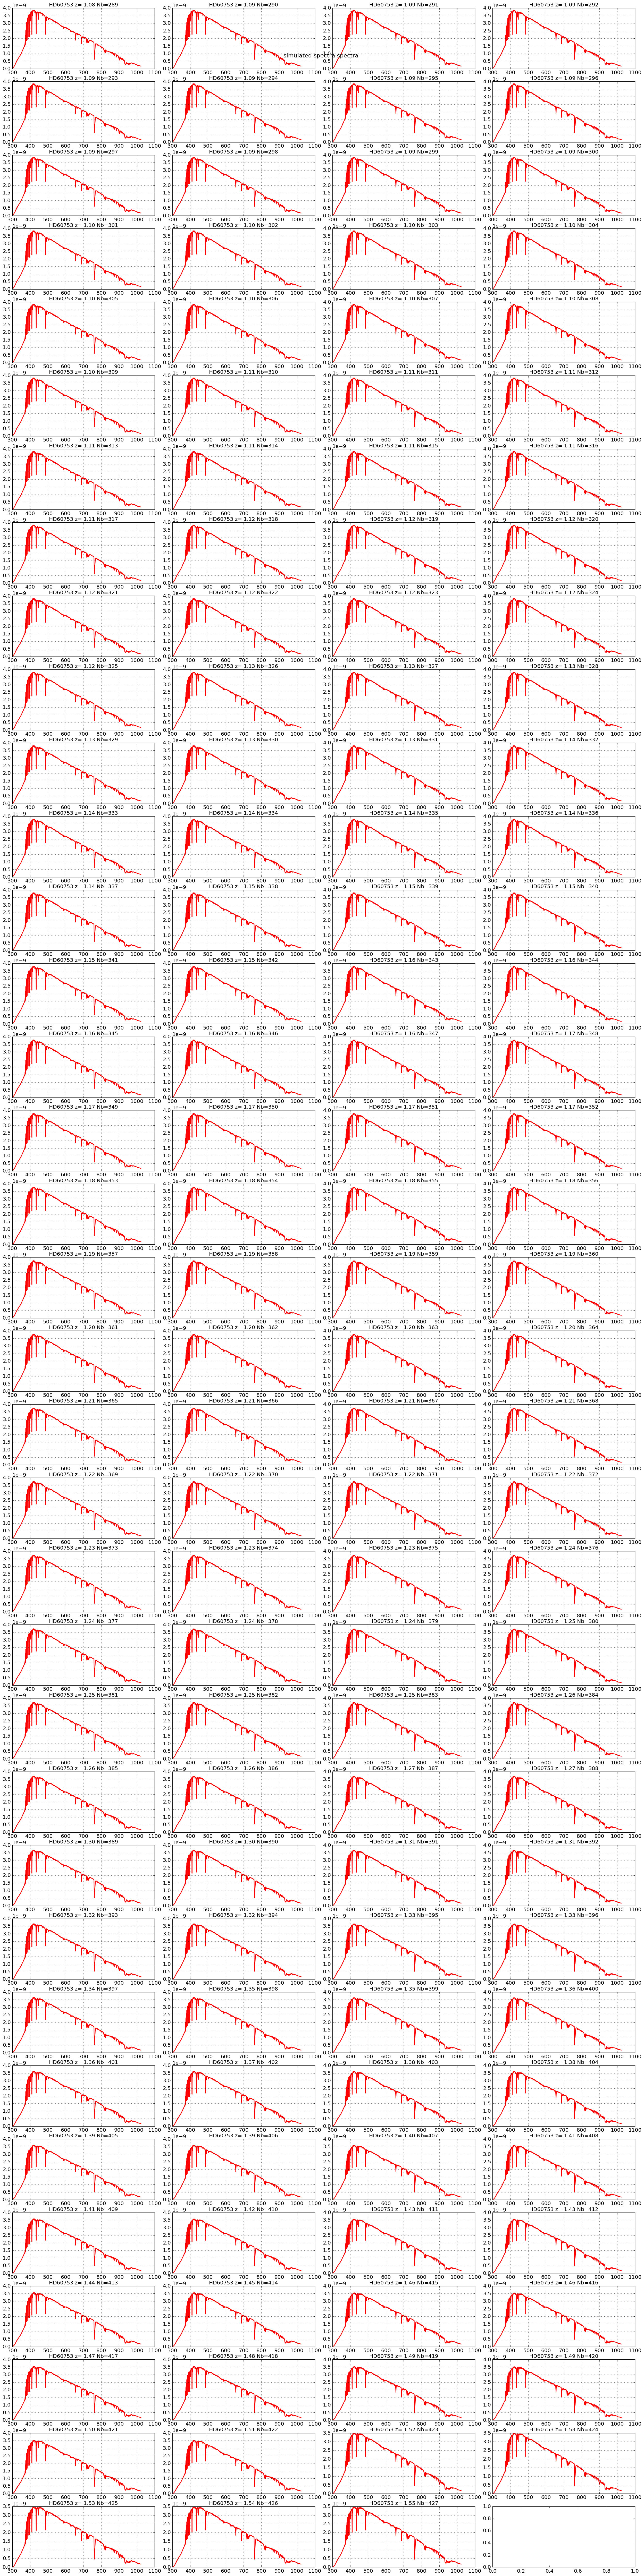

In [84]:
ShowSpectra(all_simwavelength,all_simspectra,all_simtitles,object_name,dir_top_images)

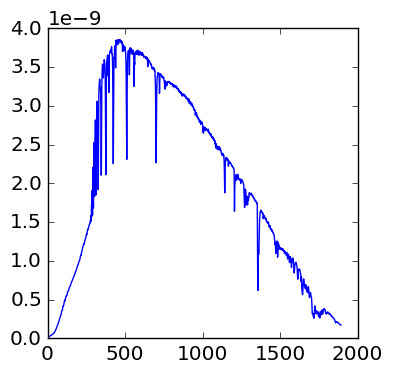

In [73]:
plt.plot(all_simspectra[0])

In [74]:
len(all_simwavelength[0])

1894

In [75]:
def MakeSimNpArray(all_simwavelength,all_simspectra):
    
    all_simspectra=np.array(all_simspectra)
    simwavelength=np.array(all_simwavelength[0])
    
    NBSPEC=all_simspectra.shape[0]
    NBWL=simwavelength.shape[0]
    
    print NBSPEC,' , ',NBWL
    dataout=np.zeros((NBSPEC+1,NBWL))
    
    dataout[0,:]=simwavelength
    
    for ispec in np.arange(1,NBSPEC+1):
        dataout[ispec,:]=all_simspectra[ispec-1]
    return dataout
    

In [76]:
spectra_out=MakeSimNpArray(all_simwavelength,all_simspectra)

139  ,  1894


In [77]:
spectra_out.shape

(140, 1894)

In [78]:
spectra_out[0,:]

array([  300.01486206,   300.15185547,   300.28884888, ...,  1021.45147705,
        1021.93859863,  1022.42565918])

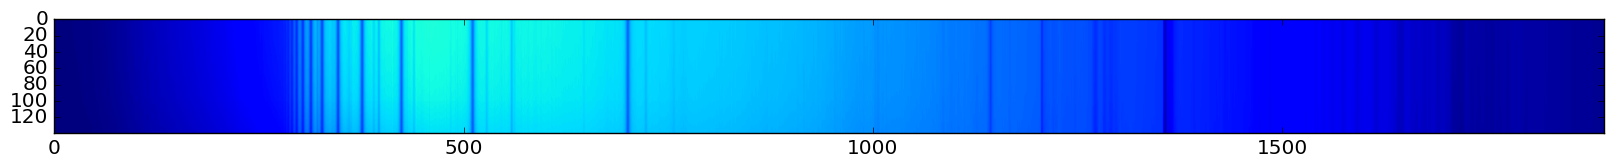

In [79]:
plt.figure(figsize=(20,20))
plt.imshow(spectra_out[:,:],vmin=0,vmax=1e-8)

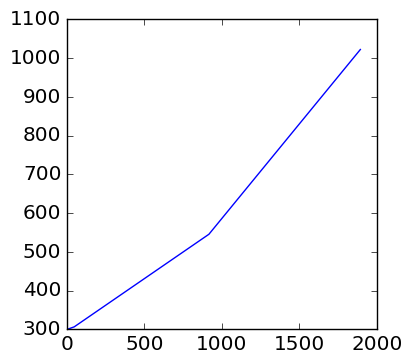

In [80]:
plt.plot(spectra_out[0,:])

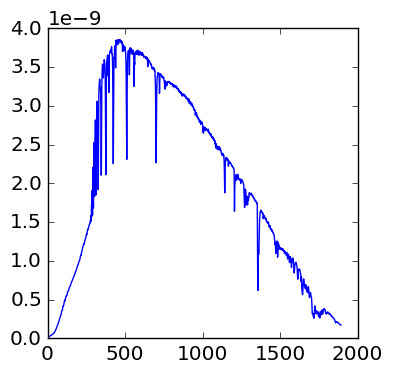

In [81]:
plt.plot(spectra_out[1,:])

### Save output fits file

In [82]:
prihdu = fits.PrimaryHDU(data=spectra_out)
thdulist = fits.HDUList(prihdu)
thdulist.writeto(outputfitsfile,clobber=True)